## DDrad sequencing

In this project we try to implement DDrad sequencing. In order to eliminate the cost of sequencing we utilize restriction enzymes. Those enzymes cut the dna sequence in specific fragments related to their site ending up with subsequences having significant smaller length than the original dna sequence. 
The next step is mapping. Utilizing algorithms like bwa and samtools, we try to find the best map for a set of wine varieties in a reference genome.
In the last step, we analyse the SNPs on those fragments with respect to the genome, trying to investigate which couple of restriction enzymes is giving the largest fragments with the maximum number of SNPs. This is useful because the SNPs could be seen as an identifier for a wine variety.

In [195]:
# For analysis purpose we use the restriction enzyme package from library Bio.Restriction
#
# load libraries

import pandas as pd
from Bio import SeqIO, Restriction
from Bio.SeqUtils import nt_search
from Bio.Seq import Seq
import os
import sys
import seaborn as sn
import pylab as pl
import numpy as np
import PyPDF2 as pdf

In [71]:
# Load information about restriction enzymes
renAll = Restriction.AllEnzymes

Here are the attributes of AllEnzymes

'add',
 'add_nocheck',
 'add_supplier',
 'already_mapped',
 'as_string',
 'clear',
 'copy',
 'current_suppliers',
 'difference',
 'difference_update',
 'discard',
 'elements',
 'format',
 'get',
 'intersection',
 'intersection_update',
 'is_restriction',
 'isdisjoint',
 'issubset',
 'issuperset',
 'lambdasplit',
 'mapping',
 'pop',
 'remove',
 'search',
 'show_codes',
 'split',
 'suppl_codes',
 'suppliers',
 'symmetric_difference',
 'symmetric_difference_update',
 'union',
 'update'
 

In [72]:
#number of restriction enzymes
print("Restriction enzymes are",len(renAll.elements()))
for e in renAll.elements()[:10]:
    print(e, end = " ")
print(" and so on...")

Restriction enzymes are 1065
AanI AarI AasI AatII Aba13301I Aba6411II AbaB8342IV AbaCIII AbaPBA3II AbaSI  and so on...


In [73]:
#attributes of enzyme class
for at in dir(renAll.get("BcoDI"))[59:]:
    print(at, end = "   ")

all_suppliers   buffers   catalyse   catalyze   charac   characteristic   compatible_end   compsite   cut_once   cut_twice   dna   elucidate   equischizomers   freq   frequency   fst3   fst5   id   inact_temp   is_3overhang   is_5overhang   is_ambiguous   is_blunt   is_comm   is_defined   is_equischizomer   is_isoschizomer   is_methylable   is_neoschizomer   is_palindromic   is_unknown   isoschizomers   mro   neoschizomers   opt_temp   overhang   ovhg   ovhgseq   results   scd3   scd5   search   site   size   substrat   suppl   supplier_list   suppliers   uri   

In [123]:
# Read additional information about restriction enzymes from xlsx file
infofile = pd.read_csv("/home/loukas/Documents/bioinformatics/ddrad RE double digest.xlsx - RE characteristics.tsv", sep="\t")
#infofile

In [196]:
#infofile.columns

In [197]:
palindromic_indexes = infofile["Palindromic enzymes"] == "Yes"

# Select palindromic enzymes
restr = infofile.loc[palindromic_indexes, "RE"]

print("These are the {} palindromic enzymes\n".format(len(restr)))
for e in restr:
    print(e, end="  ")
    

These are the 64 palindromic enzymes

AatII  Acc65I  AclI  AflII  AgeI  ApaI  ApaLI  AscI  AseI  AsiSI  AvrII  BamHI  BclI  BfaI  BfuCI  BglII  BmtI  BsiWI  BspDI  BspEI  BspHI  BsrGI  BssHII  BstBI  CviAII  CviQI  EagI  EcoRI  FatI  FseI  HhaI  HindIII  HinP1I  HpaI  HpyCH4IV  KasI  KpnI  MluCI  MluI  MseI  NarI  NcoI  NdeI  NgoMIV  NheI  NlaIII  NotI  NsiI  PacI  PaeR7I  PciI  PluTI  PspOMI  PstI  PvuI  SacI  SacII  SalI  SbfI  SpeI  SphI  TaqaI  TspMI  XbaI  

In [198]:
# Extract recognition sites of palindromic enzymes
restrsites = infofile.loc[palindromic_indexes, "recognition site /cut"]
restrsites = restrsites.str.replace("/", "")
restrsites = pd.Series(restrsites.values, index=infofile.loc[palindromic_indexes, "RE"])

In [201]:
# Keep all the palindromic enzymes in RestrictionBatch class

from Bio.Restriction import *

renz = RestrictionBatch([])
renz2 = []

for i in restr.index:
#    print(i, restr[i], end="  ")
    if i not in [39,205]:
        renz.add(restr[i])
        
print("These are the enzymes with the same site\n")
# drop enzymes with same site
for i in range(len(renz.elements()) - 1):
    e1 = renz.get(renz.elements()[i])
    for j in range(i+1,len(renz.elements())):
        e2 = renz.get(renz.elements()[j])
        if e1.site == e2.site:
            print(f"{e1} : {e1.site}, {e2} : {e2.site}")
            renz2.append(e2)

for e in renz2:
    if e in renz:
        renz.remove(e)
            
print("\nThere are {} palindromic restriction enzymes left".format(len(renz)))

These are the enzymes with the same site

Acc65I : GGTACC, KpnI : GGTACC
ApaI : GGGCCC, PspOMI : GGGCCC
BmtI : GCTAGC, NheI : GCTAGC
CviAII : CATG, FatI : CATG
CviAII : CATG, NlaIII : CATG
FatI : CATG, NlaIII : CATG
HhaI : GCGC, HinP1I : GCGC
KasI : GGCGCC, NarI : GGCGCC
KasI : GGCGCC, PluTI : GGCGCC
NarI : GGCGCC, PluTI : GGCGCC

There are 54 palindromic restriction enzymes left


In [202]:
# Categorize recognition sites into "frequent" if len == 4 otherwise "rare" 
frequent = RestrictionBatch([])
rare = RestrictionBatch([])

for e in renz:
    if e.size == 4:
        frequent.add(e)
    else:
        rare.add(e)

print("Enzymes frequent : {} \n{}".format(len(frequent),frequent))
print("\nEnzymes rare : {} \n{}".format(len(rare),rare))

Enzymes frequent : 7 
BfaI+CviAII...MluCI+MseI

Enzymes rare : 47 
AatII+Acc65I...TspMI+XbaI


There are 47 rare and 7 frequent restriction enzymes resulting in $47 \cdot 7 = 329$ distinct couples.

In [81]:
# Load 19 chromosomes of Vitis Vinifera
file = "/home/loukas/Documents/bioinformatics/Vitis_vinifera.fa.gz"
seqs = list(SeqIO.parse(file, "fasta"))

print("\nTotal size:",sys.getsizeof(seqs))


Total size: 248


In [82]:
# attributes and methods for dna sequence
for at in dir(seqs[0])[38:]:
    print(at,end="  ")

annotations  count  dbxrefs  description  features  format  id  islower  isupper  letter_annotations  lower  name  reverse_complement  seq  translate  upper  

In [83]:
# cut the chromosome with a pair of enzymes in O(n), where n the legth of chromosome
# returns the positions of the double digest fragments

def double_digest(chromosome,enz1, enz2):
    enzpos1 = enz1.search(chromosome.seq)
    enzpos2 = enz2.search(chromosome.seq)
    ddpos = []; start = []; end = []
    i=0; j=0
    
    if enzpos1[0] < enzpos2[0]:
        start = enzpos1
        end = enzpos2
    else:
        start = enzpos2
        end = enzpos1

    while i < len(start) and j < len(end):
        while i < len(start) and start[i] <= end[j]:
            i+=1
        
        if i == len(start):
            ddpos.append(start[i-1])
            ddpos.append(end[j])
            return ddpos
        
        ddpos.append(start[i-1])
        ddpos.append(end[j])
        
        while  j < len(end) and  end[j] <= start[i]:
            j+=1
        
        if j == len(end):
            ddpos.append(end[j-1])
            ddpos.append(start[i])
            return ddpos
        
        ddpos.append(end[j-1])
        ddpos.append(start[i])
        
    return ddpos


In [194]:
# double digest and keep fragments with 200 <= length <= 600
# fragments for each couple are stored in fasta file format:
# > enzyme1, enzyme2, chromosome_id, length
# ACGTGTG....

def ddcut():
    os.chdir("/home/loukas/Documents/bioinformatics")

    for ch_num in range(10,19):
        ch = seqs[ch_num]
        path = "chromosome" + str(ch.id)
        os.mkdir(path)
        os.chdir(path)
        for i in range(len(frequent.elements())):
            e1 = frequent.get(frequent.elements()[i])
            for j in range(len(rare.elements())):
                e2 = rare.get(rare.elements()[j])
                dd = double_digest(ch,e1,e2)

                #write to file
                filename = "chromosome" + ch.id + str(e1) + str(e2) + ".fasta"
                with open(filename, "w") as file1:
                    for k in range(0,len(dd),2):
                        if len(ch.seq[dd[k]-1:dd[k+1]-1]) >= 200 and len(ch.seq[dd[k]-1:dd[k+1]-1]) <= 600:
                            file1.write(" ".join([">", str(e1), str(e2), str(k), "chromosome_id", ch.id, "length", str(len(ch.seq[dd[k]-1:dd[k+1]-1])), "\n"]))
                            file1.write(str(ch.seq[dd[k]-1:dd[k+1]-1]) + "\n")

        os.chdir("/home/loukas/Documents/bioinformatics")

#ddcut()

In [175]:
# function that yields every line in fasta file without storing in RAM
import os
import os.path

def read_fasta(chromosome, enz1,enz2):
    if os.path.exists("/home/loukas/Documents/bioinformatics/chromosome"+str(chromosome.id))==False:
        print("No such file or directory /home/loukas/Documents/bioinformatics/chromosome"+str(chromosome.id))
        return -1
    
    os.chdir("/home/loukas/Documents/bioinformatics/chromosome"+str(chromosome.id))
    
    filename = "chromosome"+str(chromosome.id)+str(enz1)+str(enz2)+".fasta"
    
    if os.path.exists(filename)==False:
        filename = "chromosome"+str(chromosome.id)+str(enz2)+str(enz1)+".fasta"
    
    with open(filename, "r") as handle:
        for line in handle:
            yield line

In [178]:
# matrices for statistics

resMat = pd.DataFrame(0, index=frequent.elements(), columns=rare.elements() )

# number of fragments for each couple
resMatNumFrag = resMat.copy()
# summation of cut lengths for each combination
resMatLengths = resMat.copy()
# length fragments for each couple
resMatDistr = pd.DataFrame(list(), index=resMat.index, columns=resMat.columns)

In [203]:
# read the .fasta file from chromosome and build matrices for statistics

def build_matrices(chromid):
    os.chdir("/home/loukas/Documents/bioinformatics/")
    i=0
    while i < len(seqs) and int(seqs[i].id) != chromid:
#        print(i,seqs[i].id, chromid)
        i+=1
    
    if i == len(seqs):
        print(f"{chromid} id was not found\n")
        return -1

    ch = seqs[i]
    
    mnl = []
    std = []
    frq = []

    for i in range(len(frequent.elements())):
        e1 = frequent.elements()[i]
        for j in range(len(rare.elements())):
            e2 = rare.elements()[j]
            num_frag = 0
            len_frag = []
            for l in read_fasta(ch,e1,e2):
                if l[0]==">":
                    num_frag += 1
                    len_frag.append(int(l.split()[-1]))
            resMatNumFrag.loc[e1,e2] = num_frag
            resMatLengths.loc[e1,e2] = sum(len_frag)
            resMatDistr.loc[e1,e2] = len_frag
    
    return 0

In [204]:
canLengths = pd.DataFrame(0, index=resMatLengths.index, columns = resMatLengths.columns)
canLengths = resMatLengths.map(lambda x: (x-min(resMatLengths.unstack())) / (max(resMatLengths.unstack()) - min(resMatLengths.unstack())) )

#canLengths

In [205]:
canFrags = pd.DataFrame(0, index=resMatLengths.index, columns = resMatLengths.columns)
canFrags = resMatNumFrag.map(lambda x: (x-min(resMatNumFrag.unstack())) / (max(resMatNumFrag.unstack()) - min(resMatNumFrag.unstack())) )

#canFrags

In [206]:
resMatDistr = resMatDistr.fillna(0)
#resMatDistr.iloc[:10,:10]

In [207]:
# function for heatmap

def heatmap_(dataframe,fname, title):
    pl.figure(figsize=(18,8))
    hm = sn.heatmap(dataframe, cmap="Spectral",xticklabels="auto", yticklabels="auto",linewidths=0.5,annot=False)

    pl.tight_layout()
    pl.title(title+" \n")
    pl.savefig("/home/loukas/Documents/bioinformatics/"+fname+".pdf",format="pdf",dpi=600, orientation='landscape')
    pl.show()


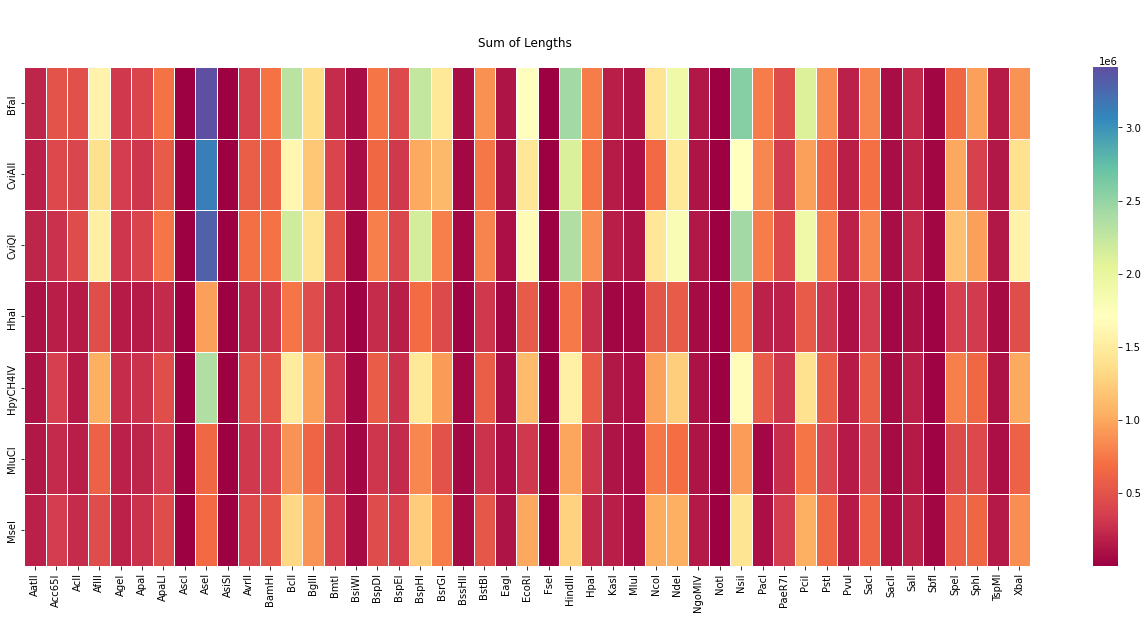

Top-10 enzymes with the largest summation of lengths:

AseI     BfaI        3411305
         CviQI       3302856
         CviAII      3129748
NsiI     BfaI        2567837
         CviQI       2430367
HindIII  BfaI        2427450
         CviQI       2352923
AseI     HpyCH4IV    2348085
BclI     BfaI        2292827
BspHI    BfaI        2249373
dtype: int64


In [208]:
lengthsTop10 = resMatLengths.unstack().nlargest(10)
heatmap_(resMatLengths,"fraglen", "\n\nSum of Lengths")

print("Top-10 enzymes with the largest summation of lengths:\n")
print(lengthsTop10)

Top-10 enzymes with the largest number of fragments:

AseI     BfaI        9559
         CviAII      9302
         CviQI       9012
NsiI     BfaI        7184
HindIII  BfaI        6826
NsiI     CviQI       6613
HindIII  CviQI       6391
BclI     BfaI        6354
AseI     HpyCH4IV    6322
BspHI    BfaI        6251
dtype: int64


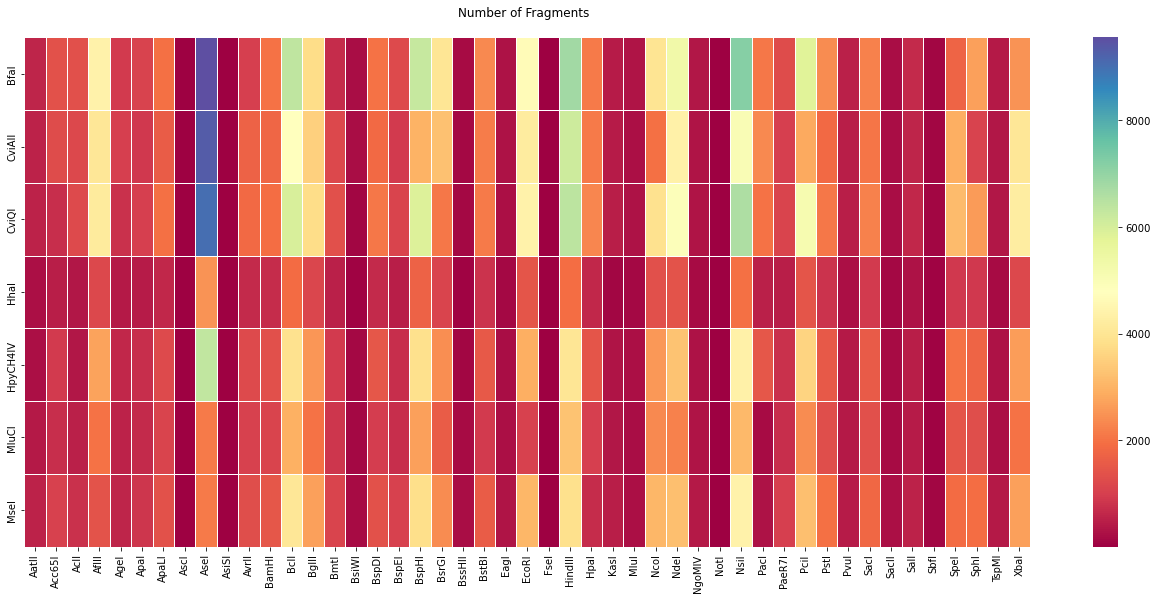

In [209]:
# Number of fragments per enzyme

numFragTop10 = resMatNumFrag.unstack().nlargest(10)
print("Top-10 enzymes with the largest number of fragments:\n")
print(numFragTop10)

heatmap_(resMatNumFrag,"Numfrags","Number of Fragments ")


In [210]:
# meanDistr
meanDistr = resMatDistr.map(lambda x: np.mean(x))
stdDistr = resMatDistr.map(lambda x: np.std(x))

In [211]:
#meanDistr

canMean = pd.DataFrame(0, index=meanDistr.index, columns = meanDistr.columns)
canMean = meanDistr.map(lambda x: (x-min(meanDistr.unstack())) / (max(meanDistr.unstack()) - min(meanDistr.unstack())) )

#canMean

In [212]:
stdDistr

canStd = pd.DataFrame(0, index=stdDistr.index, columns = stdDistr.columns)
canStd = stdDistr.map(lambda x: (x-min(stdDistr.unstack())) / (max(stdDistr.unstack()) - min(stdDistr.unstack())) )

#canStd

Top-10 enzymes with smallest std lengths

AscI     HhaI        18.208667
         HpyCH4IV    64.488836
AsiSI    MluCI       64.897877
NotI     HhaI        68.892473
AsiSI    HpyCH4IV    71.474160
         BfaI        81.266219
FseI     MseI        85.542901
HpaI     MluCI       88.422196
HindIII  MluCI       90.531095
BsrGI    MluCI       90.551675
dtype: float64


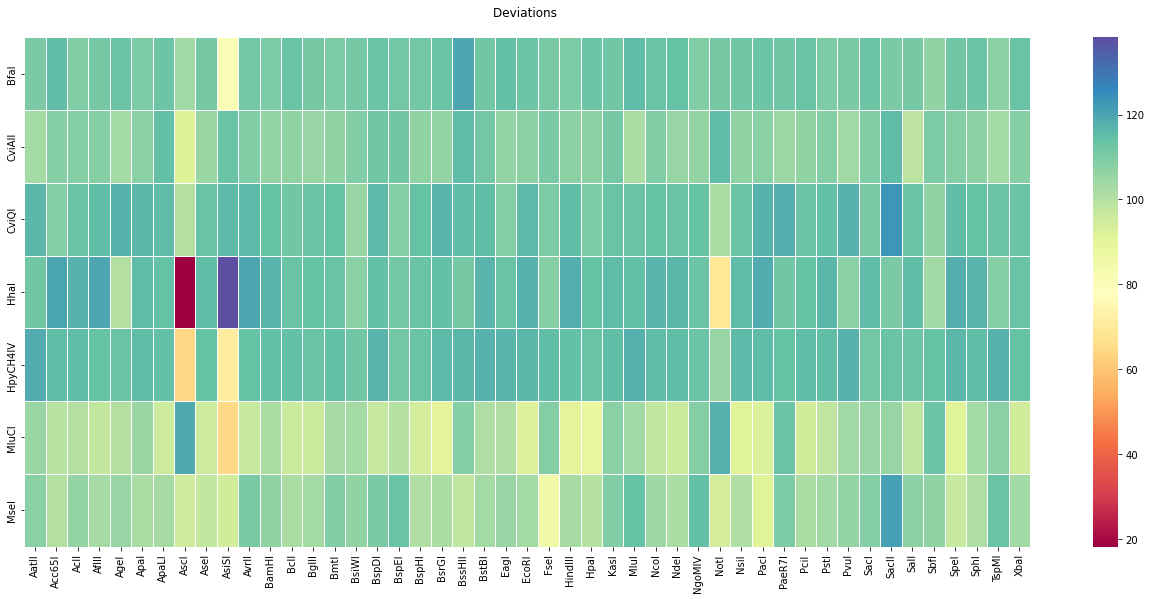

In [213]:
# Deviations

stdBottom10 = stdDistr.unstack().nsmallest(10)
print("Top-10 enzymes with smallest std lengths\n")
print(stdBottom10)

heatmap_(stdDistr,"deviationHeatmap", "Deviations")

Top-10 enzymes with largest mean lengths

HpaI   HhaI        407.752809
NotI   CviQI       404.555556
PvuI   HpyCH4IV    403.964467
SpeI   HhaI        398.209932
AclI   HpyCH4IV    397.712291
PacI   HhaI        396.436620
AclI   HhaI        395.354667
BglII  HhaI        394.835556
AgeI   HhaI        394.489529
BsrGI  HhaI        393.665171
dtype: float64


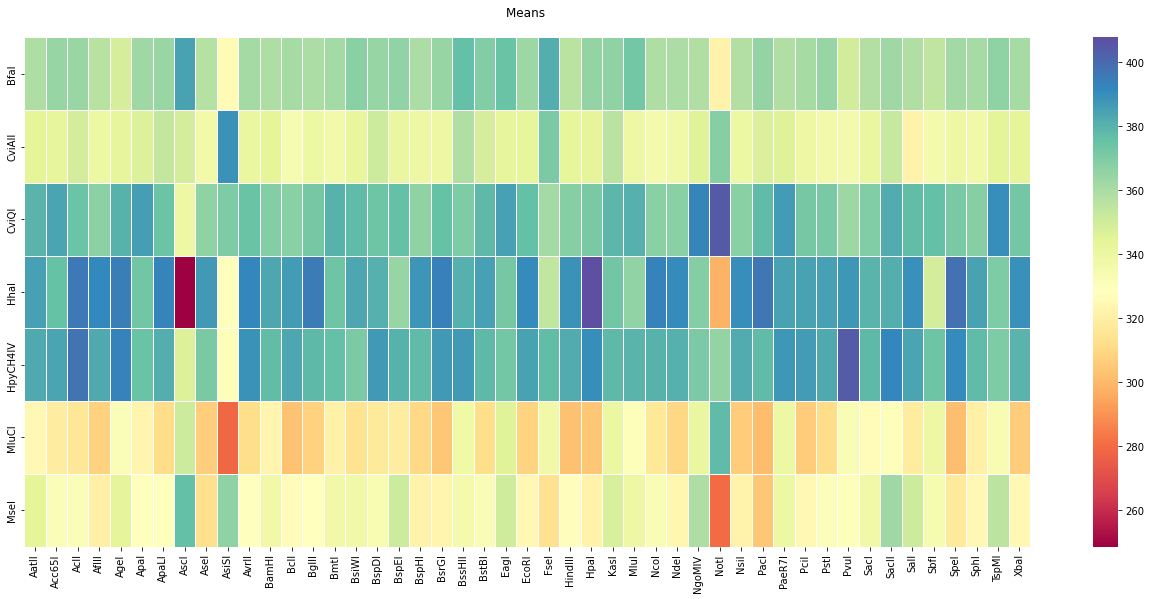

In [214]:
# Means
        
meanTop10 = meanDistr.unstack().nlargest(10)
print("Top-10 enzymes with largest mean lengths\n")
print(meanTop10)

heatmap_(meanDistr,"meansHeatmap", "Means")

In [215]:
stdDown10 = stdDistr.unstack().nsmallest(10)
#stdDown10


Best enzymes

AseI     BfaI        0.726439
         CviQI       0.714546
         CviAII      0.678982
NsiI     BfaI        0.601085
         CviQI       0.589945
HindIII  BfaI        0.583428
AseI     HpyCH4IV    0.580393
HindIII  CviQI       0.576091
BclI     BfaI        0.561754
BspHI    BfaI        0.558200
dtype: float64


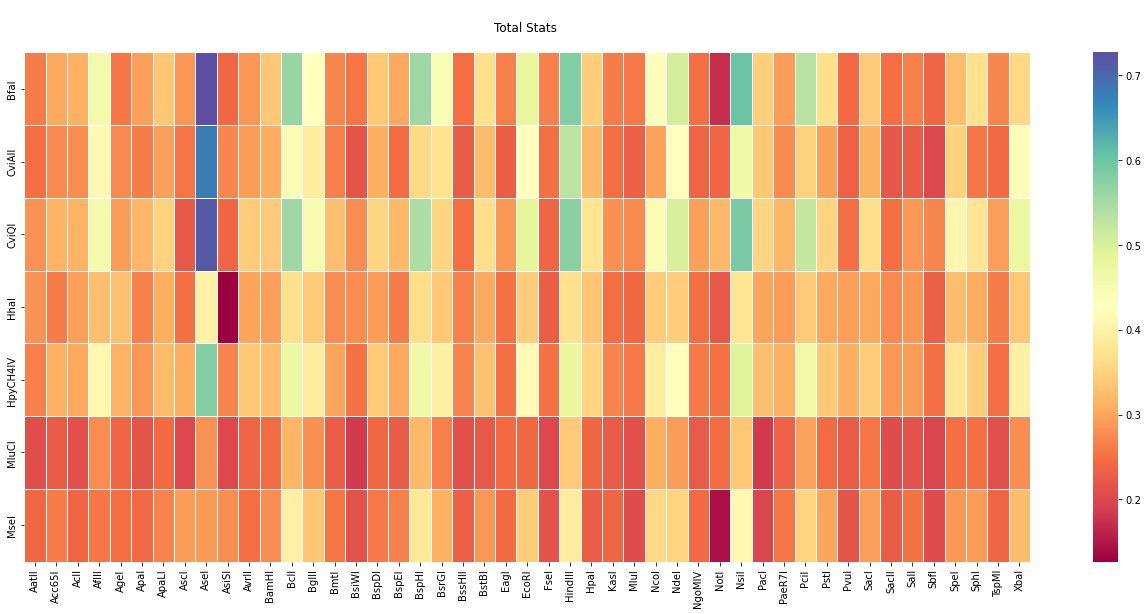

In [216]:
# Combine the above matrices and make totalStats data frame
# For each couple of enzymes we have a statistic number sn in (0,1)
# Close to 0 means low sum of lengths, low number of fragments, low mean length and high deviation whereas
# Close to 1 means high sum of lengths, high number of fragments, high mean length and low deviation

totalStats = pd.DataFrame(0., index = resMatDistr.index, columns = resMatDistr.columns)

T=0

for e1 in totalStats.index:
    for e2 in totalStats.columns:
        T += canLengths.loc[e1,e2]
        T += canFrags.loc[e1,e2]
        T += canMean.loc[e1,e2]
        T += (1 - canStd.loc[e1,e2])
        totalStats.loc[e1,e2] = T/4
        T = 0

totalStats

totalTop10 = totalStats.unstack().nlargest(10)
print("\nBest enzymes\n")
print(totalTop10)

heatmap_(totalStats, "TotalHeatmap","\nTotal Stats")

In [217]:
# find best enzymes for each chromosome
# print the top-5 with statistic number

for ch in seqs:
    bb = build_matrices(int(ch.id))
    
    if bb==0:
        meanDistr = resMatDistr.map(lambda x: np.mean(x))
        stdDistr = resMatDistr.map(lambda x: np.std(x))

        canLengths = pd.DataFrame(0, index=resMatLengths.index, columns = resMatLengths.columns)
        canLengths = resMatLengths.map(lambda x: (x-min(resMatLengths.unstack())) / (max(resMatLengths.unstack()) - min(resMatLengths.unstack())) )

        canMean = pd.DataFrame(0, index=meanDistr.index, columns = meanDistr.columns)
        canMean = meanDistr.map(lambda x: (x-min(meanDistr.unstack())) / (max(meanDistr.unstack()) - min(meanDistr.unstack())) )

        canStd = pd.DataFrame(0, index=stdDistr.index, columns = stdDistr.columns)
        canStd = stdDistr.map(lambda x: (x-min(stdDistr.unstack())) / (max(stdDistr.unstack()) - min(stdDistr.unstack())) )

        totalStats = pd.DataFrame(0., index = resMatDistr.index, columns = resMatDistr.columns)
        T=0

        for e1 in totalStats.index:
            for e2 in totalStats.columns:
                T += canLengths.loc[e1,e2]
                T += canFrags.loc[e1,e2]
                T += canMean.loc[e1,e2]
                T += (1 - canStd.loc[e1,e2])
                totalStats.loc[e1,e2] = T/4
                T = 0

        totalTop10 = totalStats.unstack().nlargest(5)
        print(f"\nTop 5 for chromosome {ch.id}\n")
        print(totalTop10)
        print(20*"- -")


Top 5 for chromosome 10

AseI  BfaI      0.726439
      CviQI     0.714546
      CviAII    0.678982
NsiI  BfaI      0.601085
      CviQI     0.589945
dtype: float64
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -

Top 5 for chromosome 11

AseI  BfaI      0.701529
      CviQI     0.692023
      CviAII    0.654394
NsiI  BfaI      0.574243
      CviQI     0.573190
dtype: float64
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -

Top 5 for chromosome 12

AseI  BfaI      0.702439
      CviQI     0.683686
      CviAII    0.654466
NsiI  BfaI      0.577572
      CviQI     0.572467
dtype: float64
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -

Top 5 for chromosome 13

AseI     BfaI      0.691298
         CviQI     0.677781
         CviAII    0.642373
NsiI     BfaI      0.567237
HindIII  BfaI      0.556156
dtype: float64
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -

Top 5 for chromosome 14

AseI  BfaI      0.638978
      CviQI     0.621842
 

/home/loukas/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/loukas/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/loukas/.local/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/loukas/.local/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/loukas/.local/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Top 5 for chromosome 5

AseI  BfaI      0.699617
      CviQI     0.671815
      CviAII    0.664566
NsiI  BfaI      0.580766
      CviQI     0.556974
dtype: float64
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -

Top 5 for chromosome 6

AseI  BfaI      0.732502
      CviQI     0.714459
      CviAII    0.690954
NsiI  BfaI      0.597437
      CviQI     0.583341
dtype: float64
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -

Top 5 for chromosome 7

AseI   BfaI      0.639498
       CviQI     0.613447
       CviAII    0.598490
NsiI   BfaI      0.511694
AsiSI  CviQI     0.500343
dtype: float64
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -

Top 5 for chromosome 8

AseI  BfaI        0.749103
      CviQI       0.743543
      CviAII      0.696735
      HpyCH4IV    0.626042
NsiI  CviQI       0.623638
dtype: float64
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -

Top 5 for chromosome 9

AseI     BfaI      0.687094
         CviQI     0.666332
